In [137]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime as d
from scipy import signal
from sklearn import linear_model

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet
import loadSIO as sio

# Minimization based matched field

In [138]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 2000

snapLength = 10
snapStep = 2
numSnaps = 21
sD = 54

frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencyNumber = 0
tol = 1

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
rangeTime = experimentStart + d.timedelta(0, tStart)
sourceRange = swellEx_env.getRangeAtTime(rangeTime)
print(sourceRange)

3.825


In [139]:
rangeTime

datetime.datetime(1996, 5, 10, 23, 48, 20)

In [140]:
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)

# Match field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m
numR = 50
numZ = 30

# Solver Parameters
decimation = 10
fB_width = 300

In [141]:
# load data file
sampleStart = tStart * fs
numSamples = (snapLength + (snapStep * numSnaps)) * fs
channels = -1
data = sio.load_allChannels(dataFile, channelNames = sensorPosition)

In [142]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [143]:
def getSnap(snapNum, frequencyNumber, tol = 1):
    snapSamples = np.int(snapLength * fs)
    stepSamples = np.int(snapStep * fs)

    NFFT = np.int(2 ** np.ceil(np.log2(2 * snapSamples)))

    loadRange = np.arange(snapSamples) + snapNum * stepSamples
    oneSnap = data['data'][loadRange, :]
    oneSnap *= np.kaiser(snapSamples, 2.5 * np.pi)[:,None]
    snapF = np.fft.fft(oneSnap, NFFT, axis = 0)
    f = (np.arange(NFFT) / NFFT) * fs
    snapIndex = (f >= (frequencies[frequencyNumber] - tol)) &\
    (f <= (frequencies[frequencyNumber] + tol))
    return snapF, f, snapIndex

In [144]:
# basic pwelch
offset = 0
numWindows = 10
psd = []
for i in range(offset, offset + numWindows):
    snapF, f, snapIndex = getSnap(i, frequencyNumber, tol = tol)
    psd.append(np.abs(snapF) ** 2)
psd = np.array(psd)
psd = np.mean(psd, axis=0)

1
23


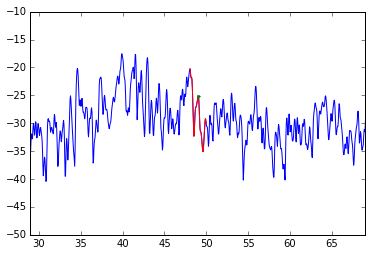

In [145]:
psdChannel = -1
plotSeries = 10 * np.log10(psd[:, psdChannel] + np.spacing(1))

_ = plt.plot(f, plotSeries)
_ = plt.plot(f[snapIndex], plotSeries[snapIndex], 'r')

_ = plt.xlim(frequencies[frequencyNumber] - 20, frequencies[frequencyNumber] + 20)
_ = plt.ylim(-50, -10)
subFreqBin = np.argmax(plotSeries[snapIndex])

peakIndex = signal.find_peaks_cwt(plotSeries[snapIndex], np.arange(3,5))
maxPeakIndex = peakIndex[np.argmax(plotSeries[snapIndex][peakIndex])]
# peakIndex = peakIndex[maxPeakIndex]
print(subFreqBin)
print(maxPeakIndex)
_ = plt.plot(f[snapIndex][maxPeakIndex], plotSeries[snapIndex][maxPeakIndex], 'g.')

In [146]:
data, _, index = getSnap(1, frequencyNumber, tol = 1)
data = data[index,:]
data = data[maxPeakIndex, :]
K = np.outer(data, data.conj())

In [147]:
# Make normalized look vectors
nm_model = Chinook(frequencies[frequencyNumber], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)
lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
W = np.dstack(lookVectors)
W = W / np.linalg.norm(W, axis = 2)[:,:,None]
W = np.nan_to_num(W)
shape_3d = W.shape
W = np.reshape(W, (shape_3d[0] * shape_3d[1], shape_3d[2]))
W = W.conj()

In [148]:
def bart_DB(K, W):
    B_bart = bartlet(K, W)
    B_bart = np.reshape(B_bart, (shape_3d[0], shape_3d[1]))
    B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
    B_bart = B_bart - np.max(B_bart)
    return B_bart

In [149]:
def bart_DB_leastSquares(W, d):
    B_bart, _, _, _ = np.linalg.lstsq(W, d)
    B_bart = np.reshape(B_bart, (shape_3d[0], shape_3d[1]))
    B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
    B_bart = B_bart - np.max(B_bart)
    return B_bart

In [152]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(W.T.conj(), data)

/usr/local/lib/python3.4/site-packages/sklearn/utils/validation.py:344: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


ValueError: Buffer dtype mismatch, expected 'DOUBLE' but got 'complex double'

In [ ]:
B_bart = bart_DB_leastSquares(W.T.conj(), d)
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Model bartlet beamforming, freq =' + str(frequencies[frequencyNumber]) + ' Hz')
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [ ]:
B_bart = bart_DB(K, W)
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Model bartlet beamforming, freq =' + str(frequencies[frequencyNumber]) + ' Hz')
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [ ]:
_ = plt.pcolormesh(np.abs(K))
_ = plt.colorbar()